In [1]:
# This source code is provided for the purposes of scientific reproducibility
# under the following limited license from Element AI Inc. The code is an
# implementation of the N-BEATS model (Oreshkin et al., N-BEATS: Neural basis
# expansion analysis for interpretable time series forecasting,
# https://arxiv.org/abs/1905.10437). The copyright to the source code is
# licensed under the Creative Commons - Attribution-NonCommercial 4.0
# International license (CC BY-NC 4.0):
# https://creativecommons.org/licenses/by-nc/4.0/.  Any commercial use (whether
# for the benefit of third parties or internally in production) requires an
# explicit license. The subject-matter of the N-BEATS model and associated
# materials are the property of Element AI Inc. and may be subject to patent
# protection. No license to patents is granted hereunder (whether express or
# implied). Copyright © 2020 Element AI Inc. All rights reserved.

"""
Tourism Experiment
"""
import logging
import os
from typing import Dict

import gin
import numpy as np
import pandas as pd
import torch as t
from fire import Fire

from common.experiment import Experiment
from common.sampler import TimeseriesSampler
from common.torch.ops import to_tensor
from common.torch.snapshots import SnapshotManager
from datasets.tourism import TourismDataset, TourismMeta
from experiments.trainer import trainer
from experiments.model import generic, interpretable
from summary.utils import group_values

In [106]:
# dataset = TourismDataset.load(training=True)

In [108]:
# import pickle
# data = {
#     'ids': dataset.ids,
#     'groups': dataset.groups,
#     'horizons': dataset.horizons,
#     'values': dataset.values
# }

# with open('TourismDataset.pkl', 'wb') as f:
#     pickle.dump(data, f)

## Dataset load

In [2]:
# TourismDataset.download()

In [ ]:
import pickle
with open('../dataset/nbeats/TourismDataset.pkl', 'rb') as f:
    data = pickle.load(f)

ids = data['ids']
groups = data['groups']
horizons = data['horizons']
values = data['values']

### Training 

In [3]:
class TourismExperiment(Experiment):
    @gin.configurable()
    def instance(self,
                 repeat: int,
                 lookback: int,
                 loss: str,
                 history_size: Dict[str, float],
                 iterations: Dict[str, int],
                 model_type: str):
        dataset = TourismDataset.load(training=True)
        with open('../dataset/nbeats/TourismDataset.pkl', 'rb') as f: 
            dataset = pickle.load(f)

        forecasts = []
        for seasonal_pattern in TourismMeta.seasonal_patterns:
            history_size_in_horizons = history_size[seasonal_pattern]
            horizon = TourismMeta.horizons_map[seasonal_pattern]
            input_size = lookback * horizon
            print(seasonal_pattern, 'L', input_size, 'H', horizon)

            # Training Set
            training_values = group_values(dataset['values'], dataset['groups'], seasonal_pattern)

            training_set = TimeseriesSampler(timeseries=training_values,
                                             insample_size=input_size,
                                             outsample_size=horizon,
                                             window_sampling_limit=int(history_size_in_horizons * horizon))

            if model_type == 'interpretable':
                model = interpretable(input_size=input_size, output_size=horizon)
            elif model_type == 'generic':
                model = generic(input_size=input_size, output_size=horizon)
            else:
                raise Exception(f'Unknown model type {model_type}')

            # Train model
            snapshot_dir = os.path.join(self.root, f'snapshots_{model_type}', seasonal_pattern)
            snapshot_manager = SnapshotManager(snapshot_dir=snapshot_dir,
                                               total_iterations=iterations[seasonal_pattern])
            model = trainer(snapshot_manager=snapshot_manager,
                            model=model,
                            training_set=iter(training_set),
                            timeseries_frequency=TourismMeta.frequency_map[seasonal_pattern],
                            loss_name=loss,
                            iterations=iterations[seasonal_pattern])

            # Build forecasts
            x, x_mask = map(to_tensor, training_set.last_insample_window())
            model.eval()
            with t.no_grad():
                forecasts.extend(model(x, x_mask).cpu().detach().numpy())

        forecasts_df = pd.DataFrame(forecasts, columns=[f'V{i + 1}' for i in range(np.max(TourismMeta.horizons))])
        forecasts_df.index = dataset['ids']
        forecasts_df.index.name = 'id'
        forecasts_df.to_csv(os.path.join(self.root, f'{model_type}_forecast.csv'))

In [4]:
exp = TourismExperiment(config_path='experiments/tourism/interpretable.gin') #interpretable.gin

In [5]:
gin.parse_config_file(exp.config_path)
exp.instance()

Yearly L 20 H 4
Quarterly L 40 H 8
Iteration 300/500, Training Loss: 0.1852
Monthly L 120 H 24
Iteration 300/300, Training Loss: 0.2589


## Prediction Results

In [56]:
import matplotlib.pyplot as plt

In [73]:
pred = pd.read_csv(f'experiments/tourism/interpretable_forecast.csv')
pred = pred.set_index('id')

In [17]:
pred_yearly = pred[:518].dropna(axis=1)
pred_quarterly = pred[518:945].dropna(axis=1)
pred_monthly = pred[945:].dropna(axis=1)

In [83]:
#dataset = TourismDataset.load(training=True)
dt_yearly = values[:518]
dt_quarterly = values[518:945]
dt_monthly = values[945:]

In [93]:
def plot_random_sample(train, pred_df, freq):
    length = {'yearly': 518, 'quarterly': 427, 'monthly': 366}
    horizon = {'yearly': 4, 'quarterly': 8, 'monthly': 24}

    h = horizon[freq]
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))

    for i in range(4):
        ax = axs[i // 2, i % 2] 
        
        random_index = np.random.choice(range(length[freq]))
        arr = train[random_index]

        combined_values = arr[~np.isnan(arr)][-h*5:]
        ax.plot(combined_values, label='Data', marker='o', markersize=2)

        nan_padding = [np.nan] * (len(combined_values) - h)
        pred_values = np.concatenate((nan_padding, pred_df.iloc[random_index].values))

        ax.plot(pred_values, label='Prediction', marker='o', markersize=2, color='orange')

        ax.set_title(f'NBEATS (Tourism, {freq}): Index {random_index}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Values')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

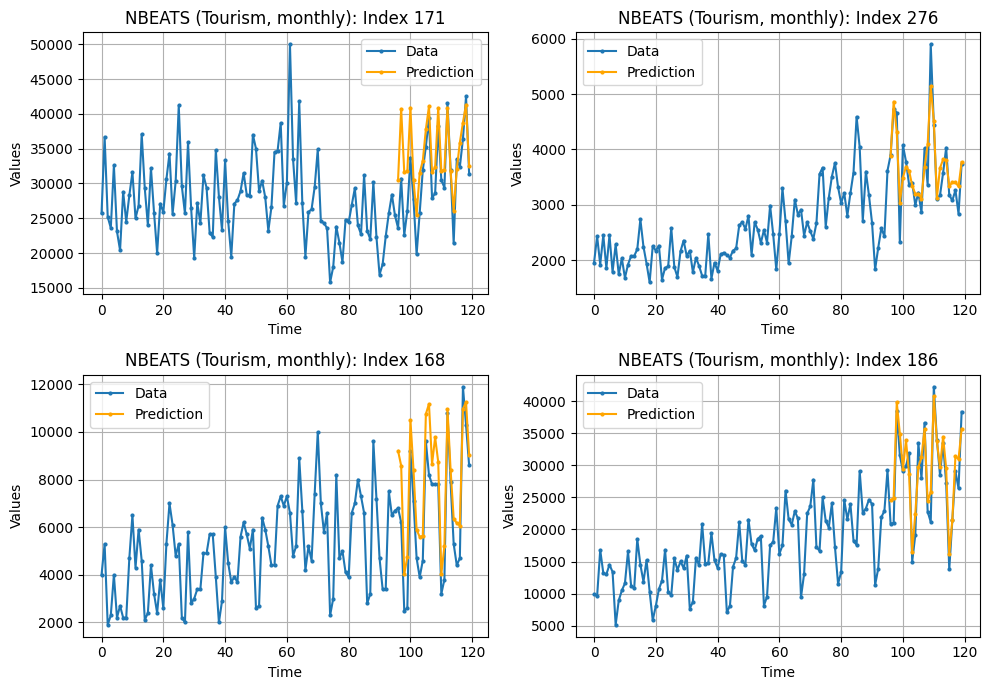

In [105]:
plot_random_sample(dt_monthly, pred_monthly, freq='monthly')

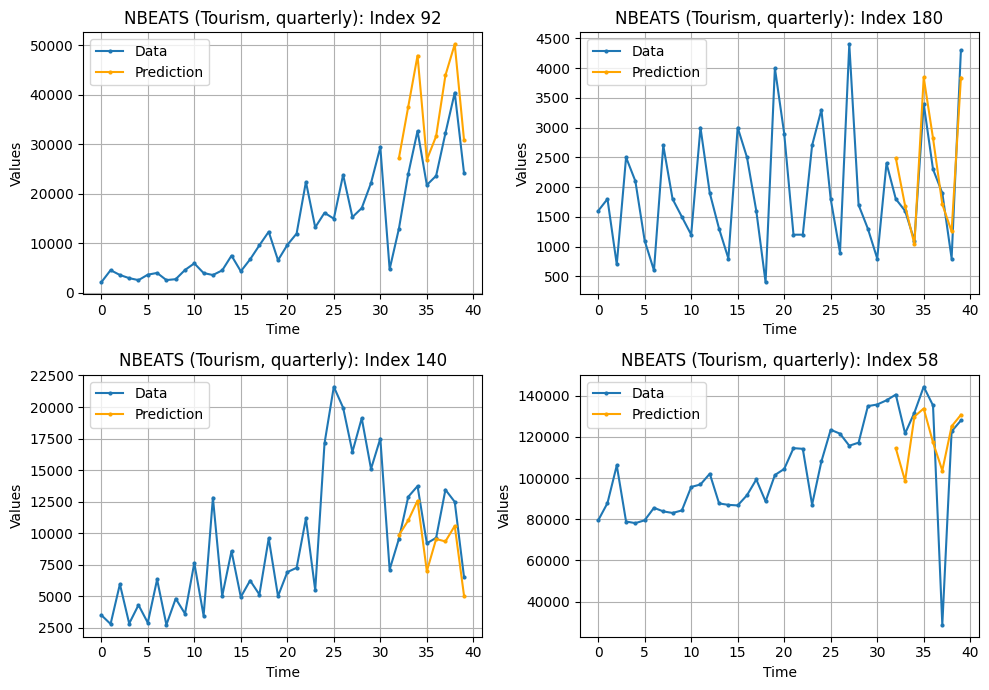

In [95]:
plot_random_sample(dt_quarterly, pred_quarterly, freq='quarterly')

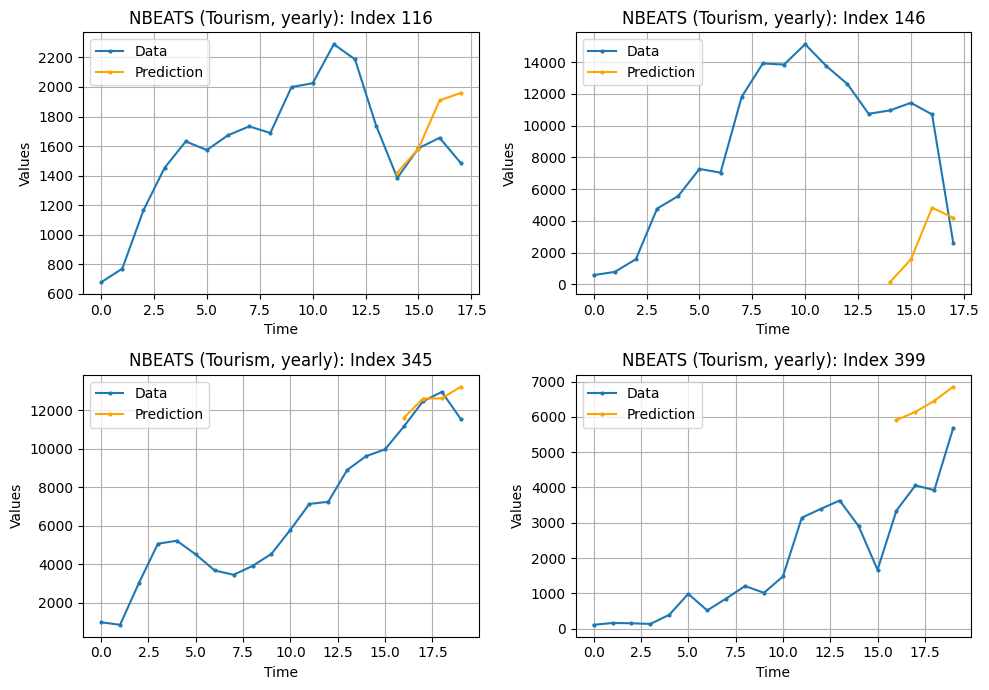

In [104]:
plot_random_sample(dt_yearly, pred_yearly, freq='yearly')